<br>
<center>
<font size="+6"><b>Group 3 Project</b></font><br><br>
<font size="+3"><b>Music Imagery Information Retrieval</b></font><br>
</center>

<br><br>

- Students: *Elias Düker, Leon Grund, Jakob Prager, Veronika Pressler*
- Course: *Neuroinformatics: Machine Learning for Neuronal Data Analysis (2022W)*
- Deadline: *January 26, 2023*

<br>

**Todo's.**
- [ ] Abstract 
- [ ] Data
- [ ] Preprocessing
- [ ] Methods &#9888;&#65039;
- [ ] Experiments
- [ ] Results

<br>

**Abstract summary.**
<font color="red">Here some words what we do in the following and a short summary of the results. I guess we don't need a Introduction and Conclusion section in this notebook...</font>

<br>

**Table of contents.**
1. [Raw data](#data)
2. [Preprocessing](#preprocessing)
3. [Classifier](#classifier)
4. [Experiments](#experiments)
5. [Results](#results)

<br>

**Requirements.**
Please make sure that all 10 `fif` files<sup>1</sup> can be found in a folder `data` in the same directory as this notebook, i.e.
```
project/
│   readme.md
│   this_notebook.ipynb
│
└───data/
        P01-raw.fif
        P04-raw.fif
        ...
        P14-raw.fif

```

<sub><sup>1</sup>You can download the raw files here: http://bmi.ssc.uwo.ca/OpenMIIR-RawEEG_v1/.</sub>

In [215]:
import numpy as np
import matplotlib
import sys

# mne
import mne
from mne.preprocessing import ICA, read_ica
from mne.decoding import CSP, UnsupervisedSpatialFilter

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [2]:
print('python:', sys.version.split()[0])
print('mne:', mne.__version__)
print('numpy:', np.__version__)
print('matplotlib:', matplotlib.__version__)

python: 3.8.3
mne: 1.2.3
numpy: 1.18.5
matplotlib: 3.2.2


<a id="data"></a>
# 1. Raw data

Below we show an example how to load and illustrate the raw EEG data for subject `P01`.

In [3]:
def get_raw_data(participant_ids=['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P11', 'P12', 'P13', 'P14']):
    return [mne.io.read_raw_fif(f'data/{pid}-raw.fif', verbose=0) for pid in participant_ids]

In [42]:
raw_list = get_raw_data(['P01'])

In [43]:
print(raw_list[0].info)

<Info | 11 non-empty values
 bads: 3 items (P8, P10, T8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2015-01-28 17:39:57 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>


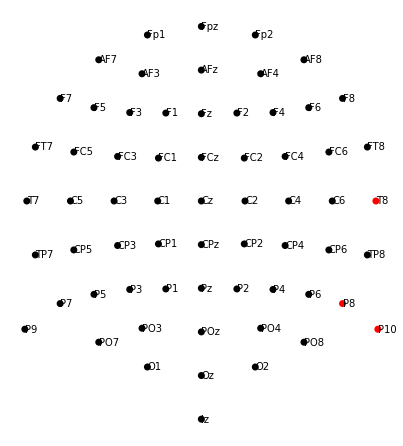

In [44]:
raw_list[0].plot_sensors(kind='topomap', show_names=True, to_sphere=True);

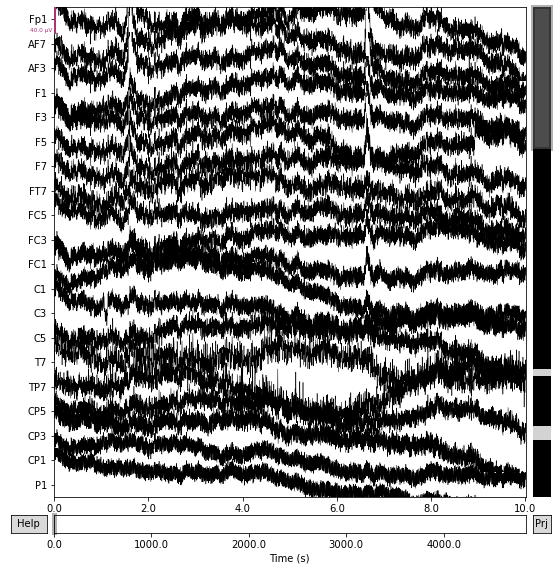

In [45]:
raw_list[0].plot();

<a id="preprocessing"></a>
# 2. Preprocessing

The function `preprocess_raw_data` takes care of all preprocessing steps such as band-pass filtering, ICA with EOG detection, and averaging. <font color="red">Are there any further steps possible? For example, PCA worked quite well in our programming assignment, right?</font>

In [247]:
def preprocess_raw_data(raw_list, l_freq=0.5, h_freq=30, ica_components=15):
    
    for raw in raw_list:       
        # band-pass filtering
        raw_filt = raw.copy().load_data().filter(l_freq=l_freq, h_freq=h_freq, phase='zero-double', verbose=0)
        
        # independent component analysis to exclude EOG events
        ica = ICA(n_components=ica_components, max_iter='auto', random_state=97, verbose=0)
        ica.fit(raw_filt, verbose=0)
        eog_indices, eog_scores = ica.find_bads_eog(raw_filt, verbose=0)
        ica.exclude = eog_indices
        raw_ica = ica.apply(raw_filt.load_data(), verbose=0)
        
        # averaging
        data_avg = data_filt.copy().load_data().set_eeg_reference(ref_channels='average', verbose=0)
        
        yield data_avg
    
    return None

In [140]:
data_list = list(preprocess_raw_data(raw_list))

Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.7s finished


<a id="methods"></a>
# 3. Methods

The implementation is similar to our programming assignment with functions `train_func`, `decision_func`. In addition, I've collected the steps to produce the labelled dataset for different event_id mappings in the function `get_labelled_dataset`. Finally, the `run_pipeline` function applies `CSP`, `StandardScaler` and `LDA` classifier.

<font color="red">We should try different classifiers as I didn't get very good results with `LDA` so far...</font>

If time permits, we could try to use `CNN` or `RNN` models, which worked quite well on similar tasks, see [Silent EEG-Speech Recognition Using Convolutional and Recurrent Neural Network with 85% Accuracy of 9 Words Classification](https://pubmed.ncbi.nlm.nih.gov/34695956/).

In [216]:
def train_func(X_train, y_train):
    clf = Pipeline([
        ("PCA", UnsupervisedSpatialFilter(PCA(10), average=False)),
        ("CSP", CSP(n_components=10, reg='ledoit_wolf', log=True)),
        ("scaler", StandardScaler()),
        ("classify", SVC())]) 
    clf.fit(X_train, y_train)
    return clf

In [217]:
def decision_func(trained_clf, X_test):
    y_pred = trained_clf.predict(X_test)
    return y_pred

In [218]:
def get_labelled_dataset(data_list, event_labels):
    xs, ys = [], []
    event_mat_list = [mne.find_events(data, stim_channel='STI 014', verbose=0) for data in data_list]
    epochs = [mne.Epochs(data, events=event_ma, event_id=list(event_labels.keys()), picks='eeg', tmin=-0.1, tmax=3.0, verbose=0) 
              for (data, event_ma) in zip(data_list, event_mat_list)]
    
    for epoch in epochs:
        xs.append(epoch.get_data())
        ys.append(np.array([event_labels.get(event_id) for event_id in epoch.events[:, 2]]))    
    return np.concatenate(xs), np.concatenate(ys)

In [219]:
def run_pipeline(data_list, event_labels):
    X_all, y_all = get_labelled_dataset(data_list, event_labels)
    
    split_obj = StratifiedKFold(n_splits=5, shuffle=True)

    acc = []

    for train_index, test_index in split_obj.split(X_all, y_all):
        # get train-test split
        X_train, X_test = X_all[train_index], X_all[test_index]
        y_train, y_test = y_all[train_index], y_all[test_index]

        # train classifier
        trained_clf = train_func(X_train, y_train)

        # predict labels
        y_pred = decision_func(trained_clf, X_test)

        # append accuracy for this fold
        acc.append(accuracy_score(y_test, y_pred))
    
    return acc

<a id="experiments"></a>
# 4. Experiments

The event markers recorded in the raw EEG comprise:
- Trial labels (as a concatenation of stimulus ID and condition) at the beginning of each trial
- Exact audio onsets for the first cue click of each trial in conditions 1 and 2 (detected by the Stimtracker)
- Subject feedback for the condition 4 trials (separate event IDs for positive and negative feedback)


For example, the event "imagining Chim Chim Cheree with lyrics and cue clicks" would be 12, since
- songs with lyrics belong the the `0`th group
- Chim Chim Cheree is the `1`st song in the group
- imagining with cue clicks is condition `2`

$\Rightarrow$ `012` = 12.

In [220]:
GROUPS = [0, 1, 2]
SONGS = [1, 2, 3, 4]
CONDS = [1, 2, 3, 4]

In [221]:
# lyrics vs non-lyrics
lyrics = [int(f'{g}{s}{c}') for g in [0] for s in SONGS for c in CONDS]
non_lyrics = [int(f'{g}{s}{c}') for g in [1] for s in SONGS for c in CONDS]

mapping_ex1 = {}
mapping_ex1.update({event_id: 0 for event_id in lyrics})
mapping_ex1.update({event_id: 1 for event_id in non_lyrics})

In [222]:
# perception vs imagination (balanced)
perception = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [1]]
imagination = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [2]]

mapping_ex2 = {}
mapping_ex2.update({event_id: 0 for event_id in perception})
mapping_ex2.update({event_id: 1 for event_id in imagination})

In [223]:
# perception vs imagination (all)
imagination_all = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [2, 3, 4]]

mapping_ex3 = {}
mapping_ex3.update({event_id: 0 for event_id in perception})
mapping_ex3.update({event_id: 1 for event_id in imagination_all})

In [224]:
# imagination with and without cue clicks
with_cue = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [2]]
without_cue = [int(f'{g}{s}{c}') for g in GROUPS for s in SONGS for c in [3]]

mapping_ex4 = {}
mapping_ex4.update({event_id: 0 for event_id in with_cue})
mapping_ex4.update({event_id: 1 for event_id in without_cue})

In [225]:
# lyrics vs non-lyrics vs instrumental
lyrics = [int(f'{g}{s}{c}') for g in [0] for s in SONGS for c in CONDS]
non_lyrics = [int(f'{g}{s}{c}') for g in [1] for s in SONGS for c in CONDS]
instrumental = [int(f'{g}{s}{c}') for g in [2] for s in SONGS for c in CONDS]

mapping_ex5 = {}
mapping_ex5.update({event_id: 0 for event_id in lyrics})
mapping_ex5.update({event_id: 1 for event_id in non_lyrics})
mapping_ex5.update({event_id: 2 for event_id in instrumental})

In [226]:
# lyrics vs instrumental
mapping_ex6 = {}
mapping_ex6.update({event_id: 0 for event_id in lyrics})
mapping_ex6.update({event_id: 1 for event_id in instrumental})

In [227]:
# non-lyrics vs instrumental
mapping_ex7 = {}
mapping_ex7.update({event_id: 0 for event_id in non_lyrics})
mapping_ex7.update({event_id: 1 for event_id in instrumental})

In [228]:
# similar setup as in Jakob's branch
mapping_ex8 = {11: 1, 12: 1, 13: 1, 14: 1, 
               21: 2, 22: 2, 23: 2, 24: 2}

<a id="Results"></a>
# 5. Results

In [229]:
results = {
    'lyrics vs non-lyrics': run_pipeline(data_list, mapping_ex1),
    'perception vs imagination (balanced)': run_pipeline(data_list, mapping_ex2),
    'perception vs imagination (all/imbalanced)': run_pipeline(data_list, mapping_ex3),
    'imagination with and without cue clicks': run_pipeline(data_list, mapping_ex4),
    'lyrics vs non-lyrics vs instrumental': run_pipeline(data_list, mapping_ex5),
    'lyrics vs instrumental': run_pipeline(data_list, mapping_ex6),
    'non-lyrics vs instrumental': run_pipeline(data_list, mapping_ex7),
    'jakobs setup': run_pipeline(data_list, mapping_ex8),
}

Using data from preloaded Raw for 160 events and 1588 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 10 dim * 5.3e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 10 dim * 5.4e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 10 dim * 5.4e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank 

Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-05 (2.2e-16 eps * 10 dim * 8.1e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 10 dim * 4.8e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-05 (2.2e-16 eps * 10 dim * 8e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Using data from preloaded Raw for 120 events and 1588 original time poi

Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 10 dim * 5.2e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Using data from preloaded Raw for 160 events and 1588 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 10 dim * 5.5e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 10 dim * 5.6e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing

Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 5.4e-06 (2.2e-16 eps * 10 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-06 (2.2e-16 eps * 10 dim * 3e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-06 (2.2e-16 eps * 10 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 10
    MAG: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-06 (2.

In [230]:
for title, acc in results.items():
    print('#####', title, '#####')
    # print('Accuracies', acc)
    print('Mean', np.mean(acc), '+/-', np.std(acc))
    print()

##### lyrics vs non-lyrics #####
Mean 0.54375 +/- 0.0960143218483576

##### perception vs imagination (balanced) #####
Mean 0.5166666666666667 +/- 0.07728015412913086

##### perception vs imagination (all/imbalanced) #####
Mean 0.7458333333333333 +/- 0.020412414523193145

##### imagination with and without cue clicks #####
Mean 0.5333333333333334 +/- 0.08897565210026094

##### lyrics vs non-lyrics vs instrumental #####
Mean 0.30833333333333335 +/- 0.056519416526043906

##### lyrics vs instrumental #####
Mean 0.5125 +/- 0.05796011559684815

##### non-lyrics vs instrumental #####
Mean 0.4875 +/- 0.082915619758885

##### jakobs setup #####
Mean 0.475 +/- 0.09354143466934853



In [274]:
# event_ma[:10]

array([[  512,     0,   121],
       [  521,     0,  1000],
       [ 8189,     0,   122],
       [ 8195,     0,  1000],
       [16565,     0,   123],
       [21614,     0,  1111],
       [21789,     0,  1000],
       [25493,     0,    31],
       [25499,     0,  1000],
       [34435,     0,    32]], dtype=int64)

In [58]:
# event_ma[-10:]

array([[2432640,       0,      14],
       [2432718,       0,    2001],
       [2443192,       0,      24],
       [2443271,       0,    2001],
       [2450980,       0,     144],
       [2451059,       0,    2001],
       [2461805,       0,     124],
       [2461884,       0,    2001],
       [2469713,       0,     224],
       [2469792,       0,    2001]], dtype=int64)